![../docs/images/banner-small.png](../docs/images/banner-small.png)

In [1]:
%matplotlib widget
from IPython.display import clear_output
from utils import CarlaEnv, CarlaSimulationConfig
import numpy as np
from dotenv import load_dotenv
import pygame
import os
import sys
import torch
import cv2
load_dotenv()
if os.environ.get("DEV", False):
    sys.path.append("../")
else:
    !pip install invertedai_drive
from invertedai_drive import Drive, Config, Jupyter_Render
clear_output()

Jupyter_Render(children=(HBox(children=(Play(value=0, description='Press play', max=0), IntSlider(value=0, des…

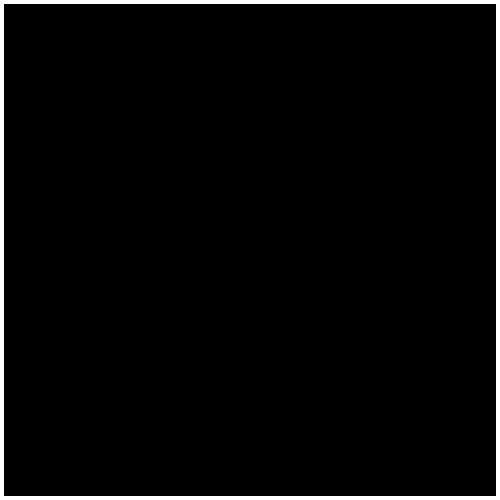

In [5]:
scene_name = "Town03_Roundabout"
agent_count = 50
episode_lenght = 30

iai_cfg = Config(location=scene_name, simulator="CARLA", agent_count=agent_count)
carla_cfg = CarlaSimulationConfig(scene_name=scene_name, episode_lenght=episode_lenght)
renderer = Jupyter_Render()
display(renderer)

In [6]:
drive = Drive(iai_cfg)
response = drive.initialize()
initial_states = response["states"][0] # Batch Size = 1

sim = CarlaEnv(cfg=carla_cfg, initial_states=initial_states, ego_spawn_point="demo")
# sim = CarlaEnv(cfg=carla_cfg) # Initial states from Carla
states, recurrent_states, dimensions = sim.reset()
clock = pygame.time.Clock()
frames = []

for i in range(carla_cfg.episode_lenght * carla_cfg.fps):
    response = drive.run(
        agent_attributes=torch.tensor(dimensions).unsqueeze(0).tolist(),
        states=torch.tensor(states).unsqueeze(0).tolist(),
        recurrent_states=torch.tensor(recurrent_states).unsqueeze(0).tolist(),
        return_birdviews=True,
    )
    states, recurrent_states, dimensions = sim.step(npcs=response, ego="autopilot")

    clock.tick_busy_loop(carla_cfg.fps)
    birdview = cv2.imdecode(np.array(response["bird_view"], dtype=np.uint8), cv2.IMREAD_COLOR)
    renderer.add_frame(birdview)
clear_output()

In [7]:
sim.destroy()